In [95]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from res_ind_lib import *

#Imports the function to plot render the policy experiments
from policy_assessment import *
from apply_policy import apply_policy


from fancy_plots import *

#ask jupyter to display the plots within this notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [5]:
#Load the excel data file into a dataframe (table)
macro=pd.read_csv("intermediate/macro.csv", 
                 index_col=economy, #tells Pandas to use the first column (Provinces) as the index of the table
                ).dropna() 

# macro=def_ref_values(macro)

#Displays the first rows of that dataframe
macro.head()


,gdp_pc_pp,pop,prepare_scaleup,borrow_abi,avg_prod_k,T_rebuild_K,pi,income_elast,rho,shareable,max_increased_spending,protection,fa_glofris,tau_tax
country,,,,,,,,,,,,,,
Albania,9960.940726,2897366,0.000000,0.162500,0.185280,3,0.2,1.5,0.06,0.8,0.05,20,0.073680,0.186757
Angola,7488.011760,21471618,0.000000,0.200000,0.432397,3,0.2,1.5,0.06,0.8,0.05,20,0.017033,0.106132
Argentina,18087.196262,41446246,0.666667,0.283333,0.269550,3,0.2,1.5,0.06,0.8,0.05,20,0.072058,0.145281
Armenia,7526.836419,2976566,0.400000,0.437500,0.366696,3,0.2,1.5,0.06,0.8,0.05,20,0.038001,0.268470
Australia,42834.016760,23129300,0.800000,0.916667,0.273602,3,0.2,1.5,0.06,0.8,0.05,20,0.041090,0.157776


In [6]:
cat_info = pd.read_csv("intermediate/cat_info.csv", index_col=[economy,"income_cat"])

cat_info.head()

n             c     axfin  gamma_SP             k  \
country   income_cat                                                        
Albania   nonpoor     0.8  11349.246839  0.092387  1.094243  61811.780436   
          poor        0.2   4407.716271  0.075853  0.623028  21560.668539   
Angola    nonpoor     0.8   8854.573906  0.201269  1.160476  20523.147061   
          poor        0.2   2021.763175  0.091791  0.358097   4494.564269   
Argentina nonpoor     0.8  21573.503341  0.060371  1.171127  80282.025353   

                            fa        v  shew  
country   income_cat                           
Albania   nonpoor     0.041340  0.31325   0.0  
          poor        0.036298  0.63000   0.0  
Angola    nonpoor     0.019437  0.50500   0.0  
          poor        0.100576  0.63000   0.0  
Argentina nonpoor     0.018010  0.30500   0.8

In [7]:
hazard_ratios = pd.read_csv("intermediate/hazard_ratios.csv", index_col=event_level+["income_cat"])

hazard_ratios.head()

fa  shew
country     hazard     rp  income_cat                
Afghanistan earthquake 20  nonpoor     0.015826     0
                           poor        0.015826     0
                       50  nonpoor     0.031746     0
                           poor        0.031746     0
                       100 nonpoor     0.051516     0

In [8]:
print("macro variables are: "+", ".join(macro.columns))
print("micro variables are: "+", ".join(cat_info.columns))
print("hazard variables are: "+", ".join(hazard_ratios.columns))

macro variables are: gdp_pc_pp, pop, prepare_scaleup, borrow_abi, avg_prod_k, T_rebuild_K, pi, income_elast, rho, shareable, max_increased_spending, protection, fa_glofris, tau_tax
micro variables are: n, c, axfin, gamma_SP, k, fa, v, shew
hazard variables are: fa, shew


# Information

In [65]:
outputs = ["risk", "resilience", "risk_to_assets"]

info = pd.DataFrame( index=outputs)
ref=compute_resilience(macro,cat_info)[outputs].dropna()


default_rp detected, droping rp


In [66]:
# (compute_resilience(macro,cat_info,hazard_ratios, return_stats=True) / compute_resilience(macro,cat_info,hazard_ratios, verbose_replace=True, return_stats=True)).dropna().T

## averages and bias in macro

In [134]:
macro["fap"] = cat_info.fa.unstack().poor
macro["far"] = cat_info.fa.unstack().nonpoor

macro["v_p"] = cat_info.v.unstack().poor
macro["v_r"] = cat_info.v.unstack().nonpoor

macro["cp"] = cat_info.c.unstack().poor
macro["cr"] = cat_info.c.unstack().nonpoor


x=cat_info[["c","n"]].prod(axis=1)
macro["share1"]=x.ix[:,"poor"]/x.sum(level="country")


In [135]:

v,pv,fa,pe= compute_v_fa(macro)

macro["v_moy"] = v
macro["fa_moy"]= fa

macro["v_bias"]  = pv
macro["fa_bias"]= pe



prout


In [136]:
v_p,v_r, far, fap, cp, cr = unpack(macro.v_moy,macro.v_bias,macro.fa_moy,macro.fa_bias,0.2,macro.share1)

macro.v_p - v_p
macro.v_r - v_r
macro.cp / cp
# macro.v_p - v_p



country
Albania                      9960.940726
Angola                       7488.011760
Argentina                   18087.196262
Armenia                              NaN
Australia                   42834.016760
Austria                     44056.254417
Azerbaijan                  16593.188760
Bangladesh                   2853.447740
Belarus                     17054.558334
Belgium                     40608.972009
Benin                        1733.309399
Bolivia                      5934.387978
Bosnia and Herzegovina       9387.350031
Botswana                    15246.608797
Brazil                      14555.082195
Bulgaria                    15695.017794
Burkina Faso                 1630.444497
Burundi                       746.960151
Cambodia                     2943.524668
Cameroon                     2739.343945
Canada                      41898.882359
Central African Republic      584.375944
Chad                         2021.593471
Chile                       21714.031556
China   

## Compute information

In [68]:
for v in macro:
    df_ = macro.dropna().copy()
    try : 
        progress_reporter(v)
        df_[v] = macro[v].mean()
        
        #bias and mean to poor and rich
        
        cat_info.v=cat_info.v.unstack().assign(nonpoor = (df_.v_moy)/(0.2* df_.v_bias+.8)).stack()
        cat_info.v=cat_info.v.unstack().assign(poor = lambda df:df.nonpoor*df_.v_bias).stack()

        cat_info.fa=cat_info.fa.unstack().assign(nonpoor = (df_.fa_moy)/(0.2* df_.fa_bias+.8)).stack()
        cat_info.fa=cat_info.fa.unstack().assign(poor = lambda df:df.nonpoor*df_.fa_bias).stack()


    except TypeError:
        pass
    
    g=compute_resilience(df_,cat_info)[outputs]
    info[v] = (((g - ref)/ref).abs()).median()

# info = info.T.sort_values("resilience", ascending=False)

working on  fa_bias
default_rp detected, droping rp


In [70]:
for v in cat_info:
#     for i in ["poor", "nonpoor"]:
        c_ = cat_info.dropna().copy()
        try : 
            c_[v] = cat_info[v].mean()
#           c_[v] = cat_info[v].unstack().assign(**{i:lambda df:df[i].mean()}).stack()
        except TypeError:
            pass

        g=compute_resilience(macro,c_,hazard_ratios)[outputs]
#         info[(v,i)] = (((g - ref)/ref).abs()).median()        
        info[v] = (((g - ref)/ref).abs()).median()

In [71]:
if False:
    for v in hazard_ratios:
#     for i in ["poor", "nonpoor"]:
        h_ = hazard_ratios.copy()
        try : 
            h_[v] = hazard_ratios[v].mean()
        except TypeError:
            pass

        g=compute_resilience(macro,cat_info,h_)[outputs]
        info[v] = (((g - ref)/ref).abs()).median()

In [69]:
info=info.T

In [70]:
info = info.rename(index=pd.read_csv("inputs/inputs_info.csv", index_col=0).descriptor)

## save info

In [71]:
with pd.ExcelWriter("results/information.xlsx", engine='xlsxwriter') as writer:
    
    workbook=writer.book
    
    info.to_excel(writer,sheet_name="information")
    worksheet=writer.sheets["information"]
    #width of the columns
    worksheet.set_column(0, 0, 20)
    worksheet.set_column(1, 1, 20)
    worksheet.set_column(2, 2, 20)
    worksheet.set_column(3, 3, 20)

    #filter
    worksheet.autofilter('A1:D1')

    #freeze panes
    writer.sheets["information"].freeze_panes(1, 1)

## barpot info

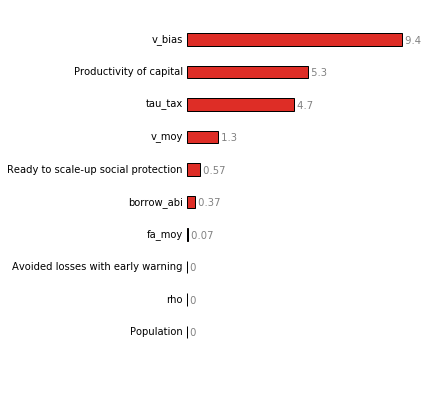

In [72]:
plot_barh(info.sort_values("resilience", ascending=True).resilience.tail(10), color="#de2d26")
plt.savefig("img/ser_info.png", bbox_inches="tight")

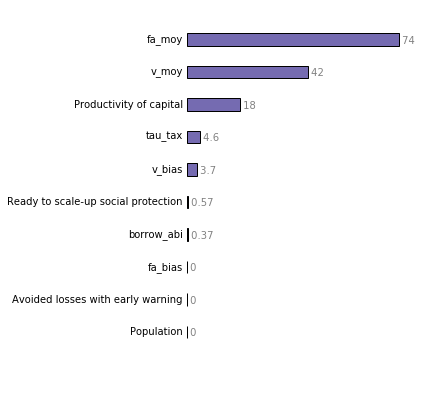

In [73]:
plot_barh(info.sort_values("risk", ascending=True).risk.tail(10), color="#756bb1", xlabel="Average error (%)")
plt.savefig("img/risk_info.png", bbox_inches="tight")

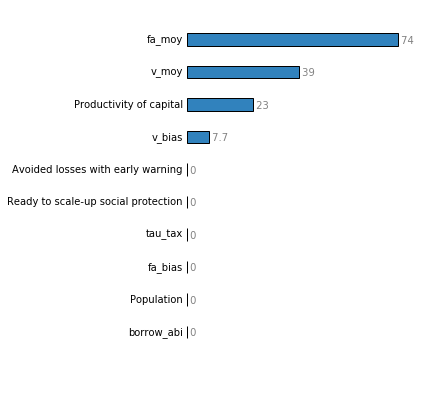

In [74]:
plot_barh(info.sort_values("risk_to_assets", ascending=True).risk_to_assets.tail(10), color="#3182bd")
plt.savefig("img/risk_to_assets_info.png", bbox_inches="tight")